#Imports

In [ ]:
# Basic utilities
import pandas as pd
import sqlite3 as sql
import numpy as np
import matplotlib.pyplot as plt

# Transformers
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

#models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#evaluation and visualization
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.target import ClassBalance

#Data Connection and Merging

In [ ]:
# Connect the data

con = sql.connect('unvotes.db')

c = con.cursor()
df = pd.read_sql_query("""WITH temp_opinions AS (
  SELECT opinions.id,
  opinions.res_token,
  opinions.vote,
  opinions.country_id,
  countries.region,
  countries.capital_lat,
  countries.capital_long
  FROM opinions
  LEFT JOIN countries
  ON opinions.country_id = countries.id
)

SELECT *
FROM temp_opinions
LEFT JOIN resolutions
ON temp_opinions.res_token = resolutions.token;""", con, parse_dates = "date")
con.close()

##New Cluster Code

In [ ]:
# imports
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [ ]:
def preprocessing(col,h_pct=0,l_pct=0):
    '''
    Cleans the text in the input column
    
    Parameters
    ----------
    col : pandas.core.series.Series
        The column which needs to be processed
    h_pct : float (default = 1)
        The percentage of high frequency words to remove from the corpus
    l_pct : float (default = 1)
        The percentage of low frequency words to remove from the corpus
    
    Returns
    -------
    cleaned text series
    '''
    #Lower case
    lower = col.apply(str.lower)
    
    #Removing HTML tags
    rem_html = lower.apply(lambda x: x.replace('#39;', "'").replace('amp;', '&')
                             .replace('#146;', "'").replace('nbsp;', ' ').replace('#36;', '$')
                             .replace('\\n', "\n").replace('quot;', "'").replace('<br />', " ")
                             .replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.')
                             .replace(' @-@ ','-').replace('\\', ' \\ ').replace('&lt;','<')
                             .replace('&gt;', '>'))
    
    #Stemming
    stem = SnowballStemmer('english')
    stemmed = rem_html.apply(lambda x: ' '.join(stem.stem(word) for word in str(x).split()))
    
    #removing punctuation
    rem_punc = stemmed.apply(lambda x: re.sub(r'[^\w\s]',' ',x))
    
    #removing stopwords and extra spaces
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    rem_stopwords = rem_punc.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
    
    #removing numbers
    rem_num = rem_stopwords.apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
    
    #remove words having length=1
    rem_lngth1 = rem_num.apply(lambda x: re.sub(r'[^\w\s]',' ',x))
    
    if h_pct != 0:
        #removing the top $h_pct of the most frequent words 
        high_freq = pd.Series(' '.join(rem_lngth1).split()).value_counts()[:int(pd.Series(' '.join(rem_lngth1).split()).count()*h_pct/100)]
        rem_high = rem_lngth1.apply(lambda x: " ".join(x for x in x.split() if x not in high_freq))
    else:
        rem_high = rem_lngth1
    
    if l_pct != 0:
        #removing the top $l_pct of the least frequent words
        low_freq = pd.Series(' '.join(rem_high).split()).value_counts()[:-int(pd.Series(' '.join(rem_high).split()).count()*l_pct/100):-1]
        rem_low = rem_high.apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
    else:
        rem_low = rem_high
    
    return rem_low

In [ ]:
df['title_short'] = preprocessing(df['title'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df.head()

,id,res_token,vote,country_id,region,capital_lat,capital_long,token,title,date,type,theme,ch_vote,fr_vote,ru_vote,uk_vote,us_vote,title_short
0,0,671248,Y,AFG,Southern Asia,34.528887,69.17246,671248,Treatment of Indians in the Union of South Africa,1946-12-08,General Assembly,7,Y,Y,Y,N,N,treatment indian union south africa
1,1,671249,A,AFG,Southern Asia,34.528887,69.17246,671249,Relations of Members of the United Nations wit...,1946-12-12,General Assembly,8,Y,Y,Y,Y,Y,relat member unit nation spain
2,2,671250,Y,AFG,Southern Asia,34.528887,69.17246,671250,Voting procedure in the Security Council,1946-12-13,General Assembly,12,A,A,N,Y,Y,vote procedur secur council
3,3,671297,X,AFG,Southern Asia,34.528887,69.17246,671297,Approval of Trusteeship Agreements [New Guinea],1946-12-13,General Assembly,9,Y,Y,N,Y,Y,approv trusteeship agreement new guinea
4,4,671308,X,AFG,Southern Asia,34.528887,69.17246,671308,Approval of Trusteeship Agreements [Western Sa...,1946-12-13,General Assembly,9,Y,Y,N,Y,Y,approv trusteeship agreement western samoa


In [ ]:
#replace certain un-specific terms

df['title_short'] = df['title_short'].str.replace('adopt', '')
df['title_short'] = df['title_short'].str.replace('general', '')
df['title_short'] = df['title_short'].str.replace('assembl', '')
df['title_short'] = df['title_short'].str.replace('resolut', '')
df['title_short'] = df['title_short'].str.replace('secur council', '')
df['title_short'] = df['title_short'].str.replace('approv', '')
df.head()

,id,res_token,vote,country_id,region,capital_lat,capital_long,token,title,date,type,theme,ch_vote,fr_vote,ru_vote,uk_vote,us_vote,title_short
0,0,671248,Y,AFG,Southern Asia,34.528887,69.17246,671248,Treatment of Indians in the Union of South Africa,1946-12-08,General Assembly,7,Y,Y,Y,N,N,treatment indian union south africa
1,1,671249,A,AFG,Southern Asia,34.528887,69.17246,671249,Relations of Members of the United Nations wit...,1946-12-12,General Assembly,8,Y,Y,Y,Y,Y,relat member unit nation spain
2,2,671250,Y,AFG,Southern Asia,34.528887,69.17246,671250,Voting procedure in the Security Council,1946-12-13,General Assembly,12,A,A,N,Y,Y,vote procedur
3,3,671297,X,AFG,Southern Asia,34.528887,69.17246,671297,Approval of Trusteeship Agreements [New Guinea],1946-12-13,General Assembly,9,Y,Y,N,Y,Y,trusteeship agreement new guinea
4,4,671308,X,AFG,Southern Asia,34.528887,69.17246,671308,Approval of Trusteeship Agreements [Western Sa...,1946-12-13,General Assembly,9,Y,Y,N,Y,Y,trusteeship agreement western samoa


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
Xwords = vectorizer.fit_transform(df['title_short'])

In [ ]:
from sklearn.cluster import KMeans
true_k = 5
modeltitlecluster = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
modeltitlecluster.fit(Xwords)
title = df['title_short']
labels = modeltitlecluster.labels_

In [ ]:
#generate word clouds for k=5

#this cell is commented out as running it may crash the notebook; we ran it separately, on the "resolutions" table of our dataset rather than the "opinions" table, but have included it here for reference

"""
from wordcloud import WordCloud
result={'cluster':labels,'title':title}
result=pd.DataFrame(result)
title_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['title'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(text)
   print('Cluster: {}'.format(k))
   print('Titles')
   titles=title_cl[title_cl.cluster==k]['title']         
   print(titles.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis('off')
   plt.show()
"""

In [ ]:
df['cluster'] = labels
df.head()

,id,res_token,vote,country_id,region,capital_lat,capital_long,token,title,date,type,theme,ch_vote,fr_vote,ru_vote,uk_vote,us_vote,title_short,cluster
0,0,671248,Y,AFG,Southern Asia,34.528887,69.17246,671248,Treatment of Indians in the Union of South Africa,1946-12-08,General Assembly,7,Y,Y,Y,N,N,treatment indian union south africa,3
1,1,671249,A,AFG,Southern Asia,34.528887,69.17246,671249,Relations of Members of the United Nations wit...,1946-12-12,General Assembly,8,Y,Y,Y,Y,Y,relat member unit nation spain,3
2,2,671250,Y,AFG,Southern Asia,34.528887,69.17246,671250,Voting procedure in the Security Council,1946-12-13,General Assembly,12,A,A,N,Y,Y,vote procedur,3
3,3,671297,X,AFG,Southern Asia,34.528887,69.17246,671297,Approval of Trusteeship Agreements [New Guinea],1946-12-13,General Assembly,9,Y,Y,N,Y,Y,trusteeship agreement new guinea,3
4,4,671308,X,AFG,Southern Asia,34.528887,69.17246,671308,Approval of Trusteeship Agreements [Western Sa...,1946-12-13,General Assembly,9,Y,Y,N,Y,Y,trusteeship agreement western samoa,3


##Encoding

In [ ]:
# drop "absent" votes
df = df[df.vote != 'X']

# sort by date
df.sort_values('date', inplace = True)
df.reset_index(inplace = True, drop = True)

# mask the SC votes as features for their own opinions
df.loc[df['country_id'] == 'CHN', ['ch_vote']] = 'Z'
df.loc[df['country_id'] == 'FRA', ['fr_vote']] = 'Z'
df.loc[df['country_id'] == 'RUS', ['ru_vote']] = 'Z'
df.loc[df['country_id'] == 'GBR', ['uk_vote']] = 'Z'
df.loc[df['country_id'] == 'USA', ['us_vote']] = 'Z'

df.head()

,id,res_token,vote,country_id,region,capital_lat,capital_long,token,title,date,type,theme,ch_vote,fr_vote,ru_vote,uk_vote,us_vote,title_short,cluster
0,642762,280453,Y,POL,Eastern Europe,52.229770,21.011780,280453,Security Council resolution 1 (1946) [on estab...,1946-01-25,Security Council,1,Y,Y,Y,Y,Y,establish militari staff committee,3
1,250793,280453,Y,EGY,Northern Africa,30.039173,31.239411,280453,Security Council resolution 1 (1946) [on estab...,1946-01-25,Security Council,1,Y,Y,Y,Y,Y,establish militari staff committee,3
2,103183,280453,Y,BRA,South America,-15.779720,-47.929720,280453,Security Council resolution 1 (1946) [on estab...,1946-01-25,Security Council,1,Y,Y,Y,Y,Y,establish militari staff committee,3
3,848961,280453,Y,USA,Northern America,38.895110,-77.036370,280453,Security Council resolution 1 (1946) [on estab...,1946-01-25,Security Council,1,Y,Y,Y,Y,Z,establish militari staff committee,3
4,164044,280453,Y,CHN,Eastern Asia,39.907500,116.397230,280453,Security Council resolution 1 (1946) [on estab...,1946-01-25,Security Council,1,Z,Y,Y,Y,Y,establish militari staff committee,3


In [ ]:
# encode categorical features
#A = 0, N = 1, X = 2, Y = 3, Z = 4
enc = OrdinalEncoder()
enc.fit(df[['country_id', 'region', 'type', 'ch_vote', 'fr_vote', 'ru_vote', 'uk_vote', 'us_vote', 'date']])
dfencoded = enc.transform(df[['country_id', 'region', 'type', 'ch_vote', 'fr_vote', 'ru_vote', 'uk_vote', 'us_vote', 'date']])

# rejoin all columns

dfencoded = pd.DataFrame(dfencoded)
dfencoded.rename(columns = {0:'country_id_num', 1:'region_num', 2:'type_num', 3:'ch_vote_num', 4:'fr_vote_num', 5:'ru_vote_num', 6:'uk_vote_num', 7:'us_vote_num', 8:'date_num'}, inplace=True)
dfencoded.head()

dffull = pd.concat([dfencoded, df], axis=1)

# Encode target ("vote")
#A = 0, N = 1, X = 2, Y = 3
le = LabelEncoder()
le.fit(dffull['vote'])
dffull['vote_num'] = le.transform(dffull['vote'])

dffull.head()

,country_id_num,region_num,type_num,ch_vote_num,fr_vote_num,ru_vote_num,uk_vote_num,us_vote_num,date_num,id,...,type,theme,ch_vote,fr_vote,ru_vote,uk_vote,us_vote,title_short,cluster,vote_num
0,143.0,6.0,1.0,3.0,3.0,3.0,3.0,3.0,0.0,642762,...,Security Council,1,Y,Y,Y,Y,Y,establish militari staff committee,3,2
1,54.0,10.0,1.0,3.0,3.0,3.0,3.0,3.0,0.0,250793,...,Security Council,1,Y,Y,Y,Y,Y,establish militari staff committee,3,2
2,23.0,14.0,1.0,3.0,3.0,3.0,3.0,3.0,0.0,103183,...,Security Council,1,Y,Y,Y,Y,Y,establish militari staff committee,3,2
3,186.0,11.0,1.0,3.0,3.0,3.0,3.0,4.0,0.0,848961,...,Security Council,1,Y,Y,Y,Y,Z,establish militari staff committee,3,2
4,32.0,5.0,1.0,4.0,3.0,3.0,3.0,3.0,0.0,164044,...,Security Council,1,Z,Y,Y,Y,Y,establish militari staff committee,3,2


#Undersampling

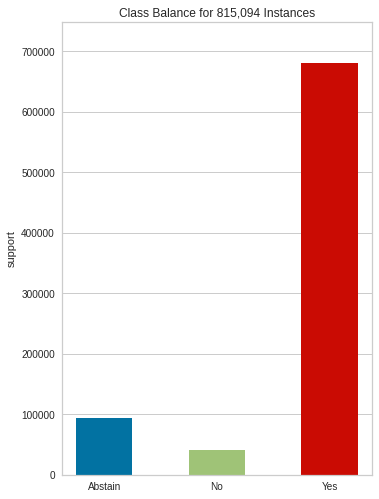

In [ ]:
ya = dffull['vote_num']

visualizer = ClassBalance(labels=['Abstain', 'No', 'Yes'], size=(400,600))

visualizer.fit(ya)
visualizer.show()

# We can see that there is a strong class imbalance, with "yes" votes vastly outnumbering "abstain" and "no"

In [ ]:
dffull['vote'].value_counts()

Y    680438
A     93520
N     41136
Name: vote, dtype: int64

In [ ]:
# Undersampling to correct for class imbalance

no_df = dffull.loc[dffull['vote'] == 'N']
abstain_df = dffull.loc[dffull['vote'] == 'A'].sample(n=41136,random_state=42)
yes_df = dffull.loc[dffull['vote'] == 'Y'].sample(n=41136,random_state=42)

# Concatenate the dataframes again, order by date (randomized within each date)
undersampled_df = pd.concat([no_df, abstain_df, yes_df])
undersampled_df = undersampled_df.sample(frac=1)
undersampled_df.sort_values(by=['date'], inplace=True)
undersampled_df.reset_index(inplace=True, drop=True)

#Setting X and y, splitting data

In [ ]:
X = undersampled_df[['country_id_num', 'region_num', 'type_num', 'ch_vote_num', 'fr_vote_num', 'ru_vote_num', 'uk_vote_num', 'us_vote_num', 'date_num', 'capital_lat', 'capital_long', 'theme', 'cluster']]
y = undersampled_df['vote_num']

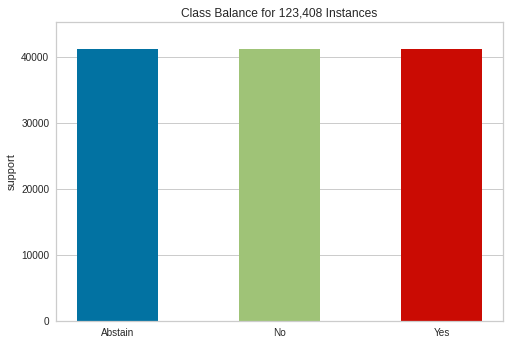

In [ ]:
visualizer = ClassBalance(labels=['Abstain', 'No', 'Yes'])

visualizer.fit(y)
visualizer.show()

# We now have balanced classes

In [ ]:
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
  print('TRAIN:', train_index, 'TEST:', test_index)
X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [    0     1     2 ... 20565 20566 20567] TEST: [20568 20569 20570 ... 41133 41134 41135]
TRAIN: [    0     1     2 ... 41133 41134 41135] TEST: [41136 41137 41138 ... 61701 61702 61703]
TRAIN: [    0     1     2 ... 61701 61702 61703] TEST: [61704 61705 61706 ... 82269 82270 82271]
TRAIN: [    0     1     2 ... 82269 82270 82271] TEST: [ 82272  82273  82274 ... 102837 102838 102839]
TRAIN: [     0      1      2 ... 102837 102838 102839] TEST: [102840 102841 102842 ... 123405 123406 123407]


#Feature Engineering

##Rank2D (Pearson Correlation)

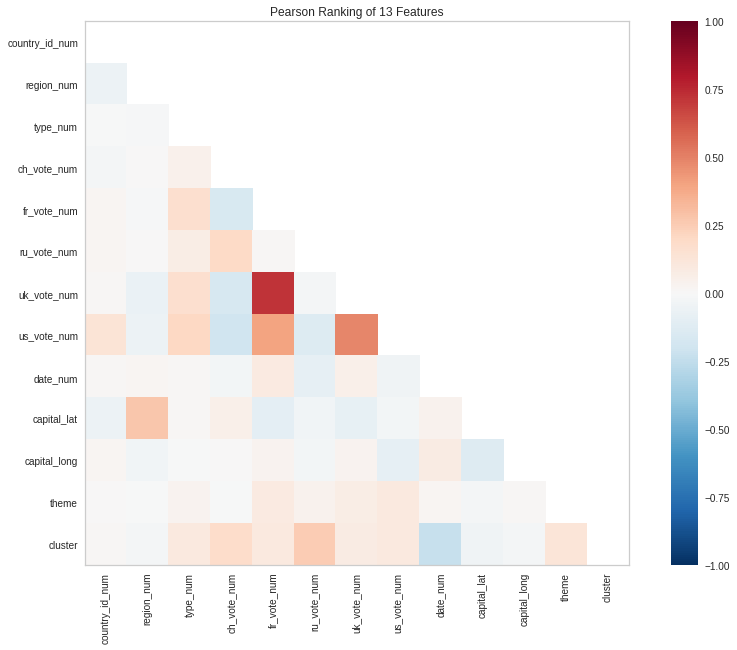

In [ ]:
from yellowbrick.features import Rank2D
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X)
visualizer.transform(X)
visualizer.show()

#Model Selection

##Initial Model Evaluation

####Classification Reports

In [ ]:
features = ['country_id_num', 'region_num', 'type_num', 'ch_vote_num', 'fr_vote_num', 'ru_vote_num', 'uk_vote_num', 'us_vote_num', 'date_num', 'capital_lat', 'capital_long', 'theme', 'cluster']

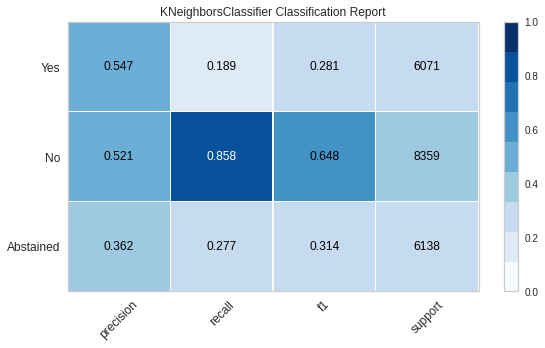

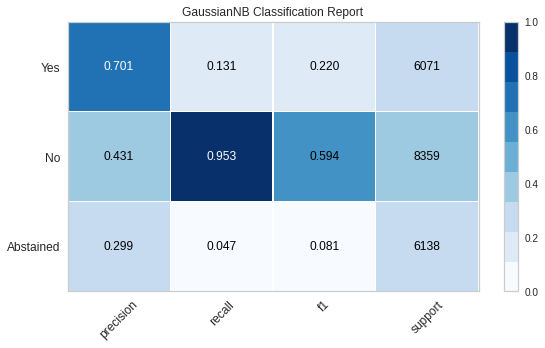

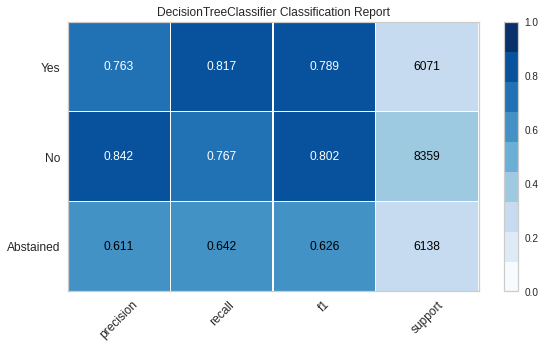

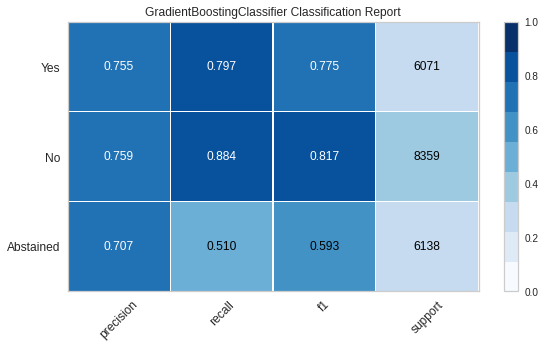

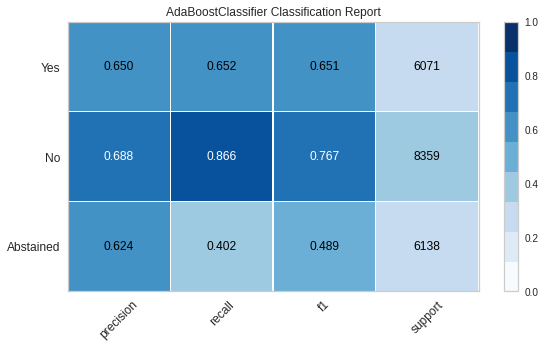

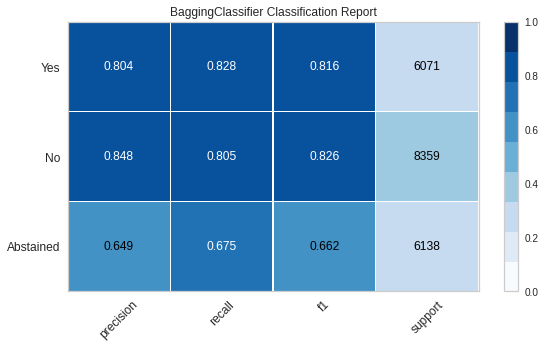

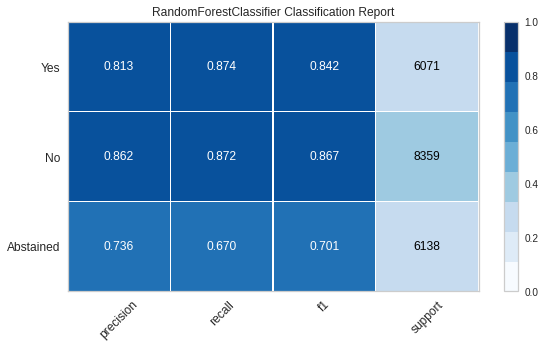

In [ ]:
models = [ 
    KNeighborsClassifier(n_neighbors=5),
    GaussianNB(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(), 
    BaggingClassifier(), 
    RandomForestClassifier()
]

def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Abstained', 'No', 'Yes'], 
        cmap='Blues', 
        support=True,
        size=(600, 360)
    )
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)

##Narrowing Down Models

Top three: Random Forest, Decision Tree, and Bagging

####Overall Scores

In [ ]:
top_models = [RandomForestClassifier(),
              BaggingClassifier(),
              DecisionTreeClassifier()]

for model in top_models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print('\n' + str(model))
  print('f1: ' )
  print(f1_score(y_test, y_pred, average = 'weighted', labels=[0, 1, 2]))
  print('precision: ' )
  print(precision_score(y_test, y_pred, average = 'weighted', labels=[0, 1, 2]))
  print('recall: ' )
  print(recall_score(y_test, y_pred, average = 'weighted', labels=[0, 1, 2]))


RandomForestClassifier()
f1: 
0.8084727938152907
precision: 
0.8079746809098741
recall: 
0.8106281602489304

BaggingClassifier()
f1: 
0.7697355261760319
precision: 
0.7719654745897381
recall: 
0.7682808245818747

DecisionTreeClassifier()
f1: 
0.7454526010548169
precision: 
0.7496609689343563
recall: 
0.743339167639051


####Confusion Matrices

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


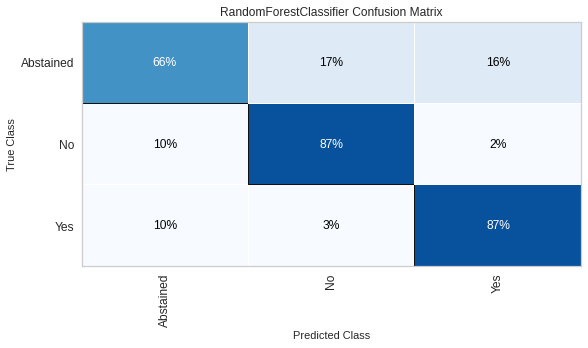

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  "X does not have valid feature names, but"


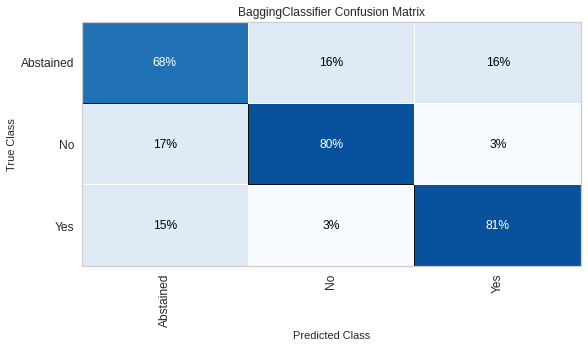

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


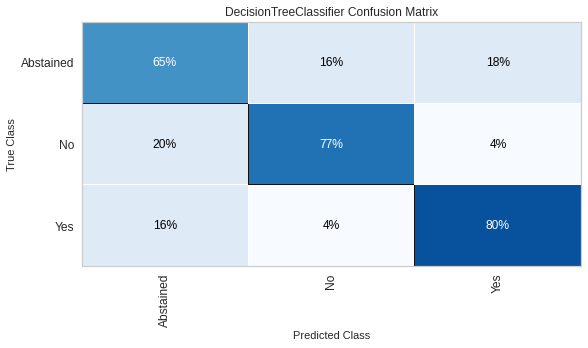

In [ ]:
def visualize_confusion(X, y, estimator):
    """
    Test various estimators.
    """ 

    # Instantiate the classification model and visualizer
    visualizer = ConfusionMatrix(
        model, 
        classes=['Abstained', 'No', 'Yes'], 
        cmap="Blues", 
        size=(600, 360),
        percent=True
    )
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in top_models:
    visualize_confusion(X, y, model)

####ROC-AUC Curves

In [ ]:
classes = ['Abstained', 'No', 'Yes']

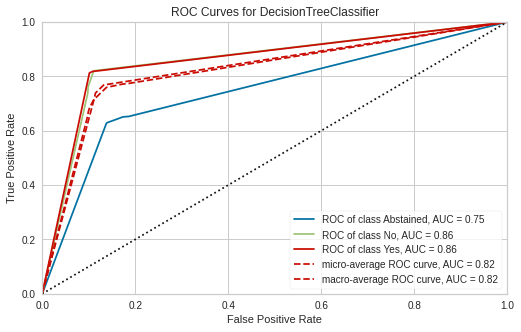

In [ ]:
#ROCAUC for DecisionTree

rocauctree = ROCAUC(
    DecisionTreeClassifier(), classes=classes, size=(600, 360)
)

rocauctree.fit(X_train, y_train)  
rocauctree.score(X_test, y_test)  
rocauctree.show()                 

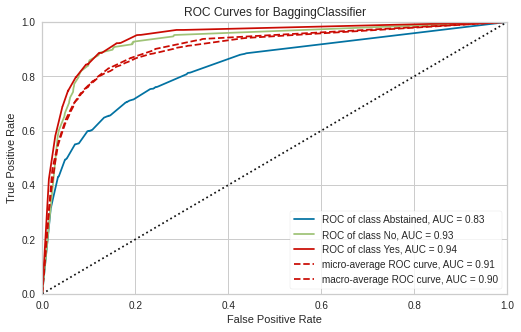

In [ ]:
#ROCAUC for BaggingClassifier

rocaucbagging = ROCAUC(
    BaggingClassifier(), classes=classes, size=(600, 360)
)

rocaucbagging.fit(X_train, y_train)  
rocaucbagging.score(X_test, y_test)  
rocaucbagging.show()                 

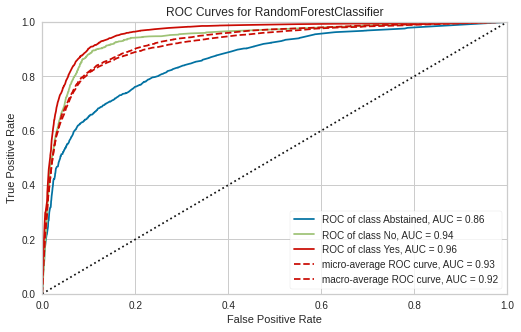

In [ ]:
#ROCAUC for RandomForest
from yellowbrick.classifier import ROCAUC

rocaucforest = ROCAUC(
    RandomForestClassifier(), classes=classes, size=(600, 360)
)

rocaucforest.fit(X_train, y_train)  
rocaucforest.score(X_test, y_test)  
rocaucforest.show()                 

#Model Tuning and Evaluation: Random Forest

In [ ]:
modelforest = RandomForestClassifier()

In [ ]:
modelforest.fit(X_train, y_train)
modelforest.score(X_test, y_test)

0.8111629716063788

####Feature Importances

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


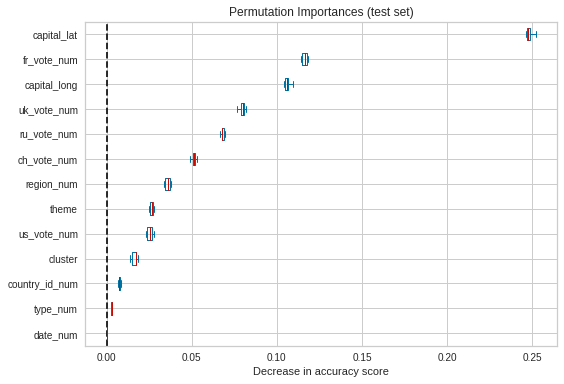

In [ ]:
#For Random Forest classifiers, feature importance overemphasizes numeric features, so we are using permutation importance instead

result = permutation_importance(modelforest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

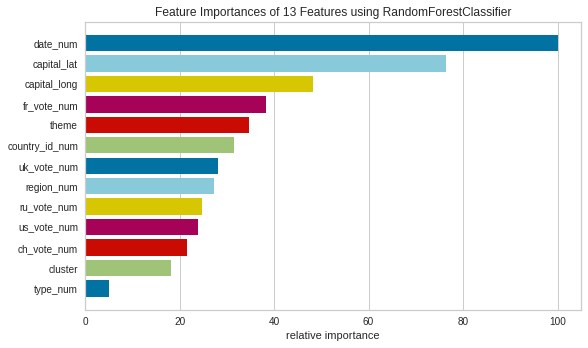

In [ ]:
#Feature importance for RandomForest

from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, labels=features, size=(600, 360))

viz.fit(X, y)
viz.show()

####Cross-Validation Scores

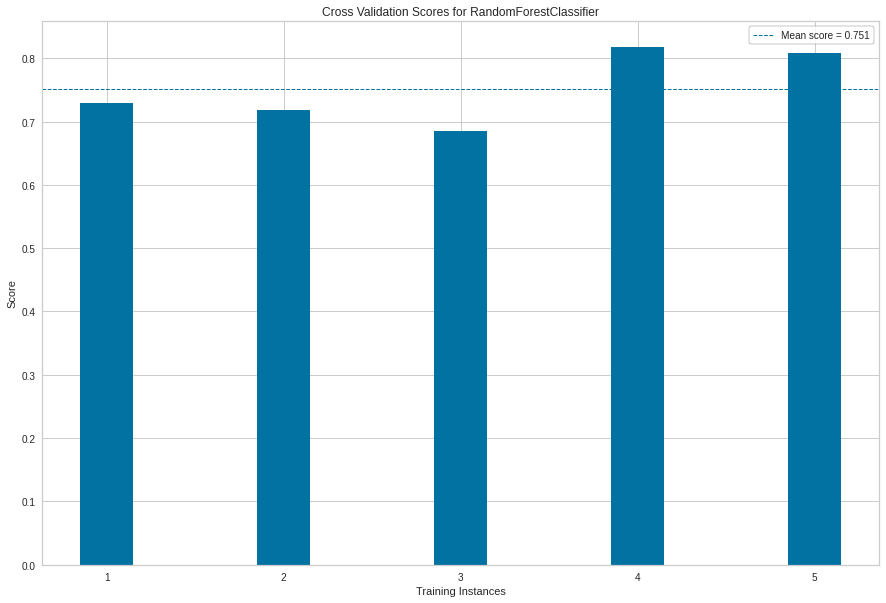

In [ ]:
from yellowbrick.model_selection import CVScores

cv = TimeSeriesSplit()

modelforest = RandomForestClassifier()
cvforest = CVScores(modelforest, cv=cv, scoring='f1_weighted', size=(1080, 720))

cvforest.fit(X, y)
cvforest.show()

###Parameter Tuning



In [ ]:
#with max_features=None

modelforest2 = RandomForestClassifier(max_features=None)

modelforest2.fit(X_train, y_train)
modelforest2.score(X_test, y_test)

0.7826234928043563

In [ ]:
#with increased n_estimators

modelforest3 = RandomForestClassifier(n_estimators=300)

modelforest3.fit(X_train, y_train)
modelforest3.score(X_test, y_test)

0.8116005445352004

In [ ]:
#with bootstrap = False

modelforest4 = RandomForestClassifier(bootstrap=False)

modelforest4.fit(X_train, y_train)
modelforest4.score(X_test, y_test)

0.7951186308829249

#Testing the Final Model

In [ ]:
Xfull = dffull[['country_id_num', 'region_num', 'type_num', 'ch_vote_num', 'fr_vote_num', 'ru_vote_num', 'uk_vote_num', 'us_vote_num', 'date_num', 'capital_lat', 'capital_long', 'theme', 'cluster']]
yfull = dffull['vote_num']

In [ ]:
#fitting the model on our training set (the undersampled data), then applying it to the full (unsampled) dataset
#note that we use X_test here rather than just X so that we will still have some unseen 'no' values in Xfull

modelforest.fit(X_test, y_test)
y_pred_full = modelforest.predict(Xfull)

In [ ]:
modelforest.score(Xfull, yfull)

0.821826685020378

In [ ]:
#scores for the overall data

print('f1: ' )
print(f1_score(yfull, y_pred_full, average = 'weighted', labels=[0, 1, 2]))
print('precision: ' )
print(precision_score(yfull, y_pred_full, average = 'weighted', labels=[0, 1, 2]))
print('recall: ' )
print(recall_score(yfull, y_pred_full, average = 'weighted', labels=[0, 1, 2]))

f1: 
0.8361819731479478
precision: 
0.8592456905462769
recall: 
0.821826685020378


In [ ]:
#scores for each class

precision,recall,fscore,support = precision_recall_fscore_support(yfull, y_pred_full, labels = [0, 1, 2])

print('precision (abstain):  {0:.4f}'.format(precision[0]))
print('precision (no):  {0:.4f}'.format(precision[1]))
print('precision (yes):  {0:.4f}'.format(precision[2]))
print('')
print('recall (abstain):  {0:.4f}'.format(recall[0]))
print('recall (no):  {0:.4f}'.format(recall[1]))
print('recall (yes):  {0:.4f}'.format(recall[2]))
print('')
print('fscore (abstain):  {0:.4f}'.format(fscore[0]))
print('fscore (no):  {0:.4f}'.format(fscore[1]))
print('fscore (yes):  {0:.4f}'.format(fscore[2]))

precision (abstain):  0.3974
precision (no):  0.4826
precision (yes):  0.9455

recall (abstain):  0.5595
recall (no):  0.7258
recall (yes):  0.8637

fscore (abstain):  0.4647
fscore (no):  0.5798
fscore (yes):  0.9027


##Country-Specific Predictions

In [45]:
#Creates a dataset consisting of only Afghanistan's votes

X_y_test = pd.concat([X_test, y_test], axis = 1)
X_y = pd.concat([X, y], axis = 1)
X_y_afg = X_y_test.loc[X_y_test['country_id_num'] == 1]
X_test_afg = X_y_afg[[col for col in X_y_afg.columns if col != 'vote_num']]
y_test_afg = X_y_afg[['vote_num']]

In [50]:
#Creates a dataset consisting of only Afghanistan's votes

X_y_afg = dffull.loc[dffull['country_id_num'] == 1]
X_test_afg = X_y_afg[['country_id_num', 'region_num', 'type_num', 'ch_vote_num', 'fr_vote_num', 'ru_vote_num', 'uk_vote_num', 'us_vote_num', 'date_num', 'capital_lat', 'capital_long', 'theme', 'cluster']]
y_test_afg = X_y_afg[['vote_num']]

In [51]:
top_model = [modelforest]

for model in top_model:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test_afg)
  print('\n' + str(model))
  print('f1: ' )
  print(f1_score(y_test_afg, y_pred, average = 'weighted', labels=[0, 1, 2]))
  print('precision: ' )
  print(precision_score(y_test_afg, y_pred, average = 'weighted', labels=[0, 1, 2]))
  print('recall: ' )
  print(recall_score(y_test_afg, y_pred, average = 'weighted', labels=[0, 1, 2]))


RandomForestClassifier()
f1: 
0.9358763708014197
precision: 
0.9537200181951784
recall: 
0.9265348060621629
